In [ ]:
!pip install dinov2

# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import AutoImageProcessor, AutoModel
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (roc_auc_score, classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix)
import seaborn as sns
import math
from sklearn.cluster import KMeans
import numpy as np

# Training Model (Supervised)

In [ ]:
# Set paths
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'

# Load the dataset
df = pd.read_csv(data_path)
df = df.dropna(subset=['Surgery diagnosis in number'])  # Drop rows with NaN labels

# Split the data
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

# Initialize DINOv2 processor and model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')

# Custom Dataset class for DINOv2 preprocessing
class CustomDataset(Dataset):
    def __init__(self, dataframe, base_path, processor):
        self.dataframe = dataframe
        self.base_path = base_path
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.dataframe.iloc[idx]['image_path'].replace('\\', '/'))
        image = Image.open(img_path).convert('RGB')
        label = int(self.dataframe.iloc[idx]['Surgery diagnosis in number'])  # Ensure label is integer

        # Apply DINOv2 preprocessing
        processed = self.processor(images=image, return_tensors="pt")
        image = processed['pixel_values'].squeeze(0)  # Remove batch dimension

        return image, torch.tensor(label, dtype=torch.long)  # Label as long for CrossEntropyLoss

# Create datasets and loaders
train_dataset = CustomDataset(train_df, base_image_path, processor=processor)
test_dataset = CustomDataset(test_df, base_image_path, processor=processor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Custom classifier on top of DINOv2
class DINOClassifier(nn.Module):
    def __init__(self, dinov2_model, num_classes=2):
        super(DINOClassifier, self).__init__()
        self.feature_extractor = dinov2_model
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():  # Freeze DINOv2 parameters
            features = self.feature_extractor(x).last_hidden_state[:, 0, :]  # CLS token
        return self.classifier(features)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = DINOClassifier(dinov2_model=feature_extractor).to(device)

# Optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Initialize placeholders for tracking metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0.0  

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    #Training 
    model.train()
    train_loss = 0.0
    correct_predictions = 0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)
            correct_predictions += (predictions == labels).sum().item()

            pbar.set_postfix(loss=loss.item())
            pbar.update(1)

    train_acc = correct_predictions / len(train_dataset)
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct_predictions = 0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            predictions = torch.argmax(outputs, dim=1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predictions.cpu().numpy())
            val_correct_predictions += (predictions == labels).sum().item()

    val_acc = val_correct_predictions / len(test_dataset)
    val_losses.append(val_loss / len(test_loader))
    val_accuracies.append(val_acc)
    val_auc = roc_auc_score(y_true, y_pred)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_Dino_Model_trial_6.pth')
        print(f"Model saved with best validation Acc: {best_val_acc:.4f}")

    # Print metrics for the epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')

# Training Graphs

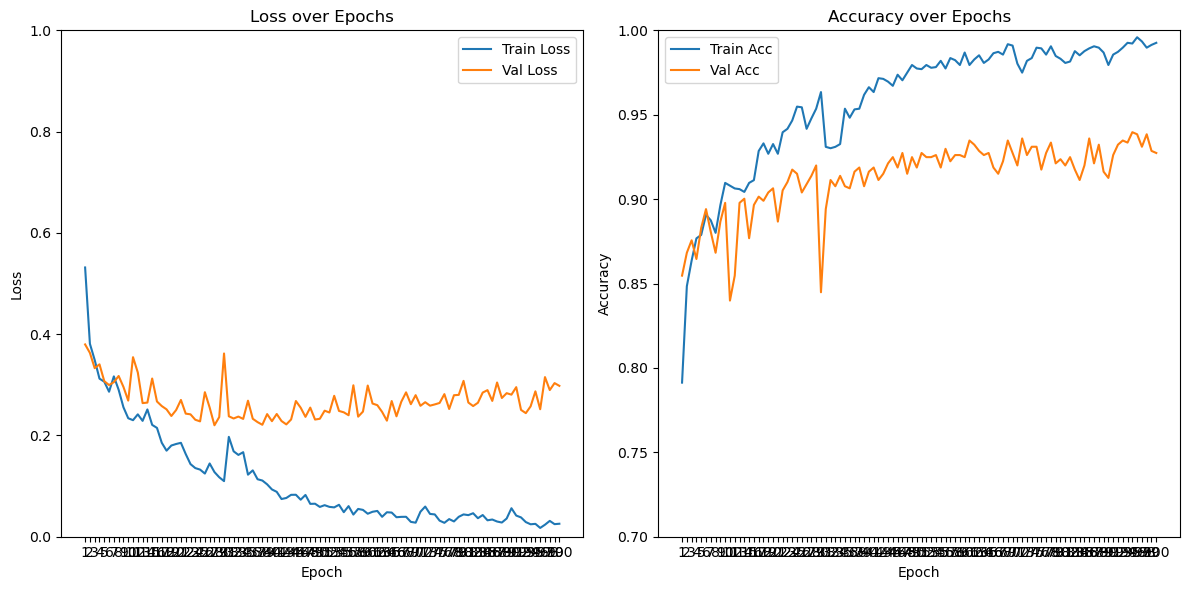

In [ ]:
# Plot training history with standardized y-axis
plt.figure(figsize=(12, 6))

# Calculate the max loss and accuracy for setting y-axis limits
max_loss = max(train_losses + val_losses)
max_acc = max(train_accuracies + val_accuracies)

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, math.ceil(max_loss))  # Y-axis from 0 to the ceiling of max_loss
plt.xticks(range(1, num_epochs + 1))  # Epochs on x-axis
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Acc')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Val Acc')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(.7, math.ceil(max_acc))  # Y-axis from 0 to the ceiling of max_acc
plt.xticks(range(1, num_epochs + 1))  # Epochs on x-axis
plt.legend()

plt.tight_layout()
plt.show()



# Testing Evaluation


Final Evaluation Metrics:
  ROC-AUC Score: 0.9753
  Accuracy: 0.9298
  F1 Score: 0.9296
  Precision: 0.9303
  Recall: 0.9298


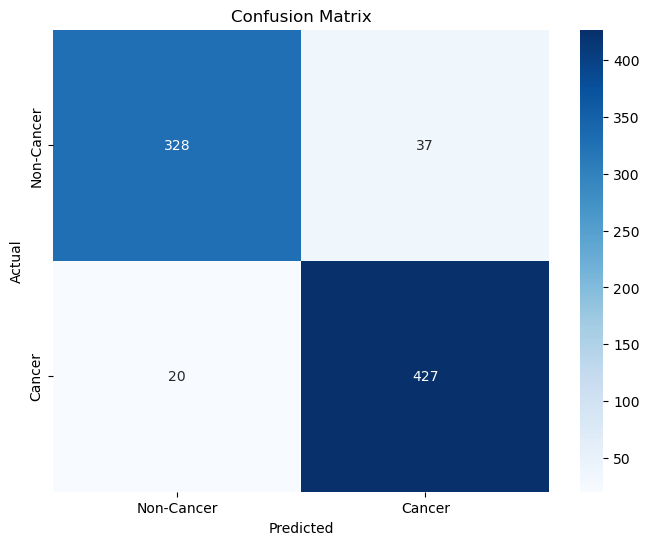

In [29]:
# Reinitialize the processor and base model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')

# Recreate the custom classifier model
class DINOClassifier(nn.Module):
    def __init__(self, dinov2_model, num_classes=2):
        super(DINOClassifier, self).__init__()
        self.feature_extractor = dinov2_model
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_extractor.config.hidden_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        with torch.no_grad():  # Freeze DINOv2 parameters
            features = self.feature_extractor(x).last_hidden_state[:, 0, :]  # CLS token
        return self.classifier(features)

# Initialize the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = DINOClassifier(dinov2_model=feature_extractor).to(device)
# Load the weights
model.load_state_dict(torch.load('/home/iambrink/NOH_Thyroid_Cancer_Data/DINOv2/trial_3/best_Dino_Model_trial_3.pth', map_location=device))


# Move to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Evaluation loop
y_true, y_pred, probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)[:, 1]
        predictions = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())
        probs.extend(probabilities.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
auc_score = roc_auc_score(y_true, probs)

print("\nFinal Evaluation Metrics:")
print(f"  ROC-AUC Score: {auc_score:.4f}")
print(f"  Accuracy: {accuracy:.4f}")
print(f"  F1 Score: {f1:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Cancer', 'Cancer'], yticklabels=['Non-Cancer', 'Cancer'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Predict Class 

In [ ]:
# Example inference on a new image
def predict(image_path, model, processor, device):
    image = Image.open(image_path).convert('RGB')
    processed = processor(images=image, return_tensors="pt")
    pixel_values = processed['pixel_values'].squeeze(0).to(device)

    model.eval()
    with torch.no_grad():
        output = model(pixel_values.unsqueeze(0))  # Add batch dimension
        prediction = torch.argmax(output, dim=1).item()

    return prediction

# Predict for a new image
image_path = "/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/002/IMG_20220908_125052.jpg"
prediction = predict(image_path, model, processor, device)
print(f"Predicted Class: {prediction}")


Predicted Class: 0


# Image Processing With Dino

In [33]:
# Load the DINOv2 model and processor
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
feature_extractor = AutoModel.from_pretrained('facebook/dinov2-base')

# Define a dataset class for DINOv2 with no labels
class UnsupervisedDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, base_path, processor):
        self.dataframe = dataframe
        self.base_path = base_path
        self.processor = processor

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = os.path.join(self.base_path, self.dataframe.iloc[idx]['image_path'].replace('\\', '/'))
        image = Image.open(img_path).convert('RGB')

        # Apply DINOv2 preprocessing
        processed = self.processor(images=image, return_tensors="pt")
        image = processed['pixel_values'].squeeze(0)  # Remove batch dimension

        return image  # Return image without label for unsupervised learning

# Create datasets and loaders
base_image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/'
data_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/Thyroid_Cancer_TAN&NOH_file.csv'

df = pd.read_csv(data_path)
df = df.dropna(subset=['image_path'])  # Ensure no missing images
dataset = UnsupervisedDataset(df, base_image_path, processor=processor)
data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# DINOv2 model for unsupervised learning
class DINOFeatureExtractor(torch.nn.Module):
    def __init__(self, dinov2_model):
        super(DINOFeatureExtractor, self).__init__()
        self.feature_extractor = dinov2_model

    def forward(self, x):
        # DINOv2 generates embeddings from the images
        with torch.no_grad():  
            features = self.feature_extractor(x).last_hidden_state[:, 0, :]  # CLS token
        return features

# Initialize the feature extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DINOFeatureExtractor(dinov2_model=feature_extractor).to(device)

# You can use the model to extract features for clustering or other tasks
# For example, obtaining embeddings for a batch of images
model.eval()
embeddings = []

# Process images
with torch.no_grad():
    for images in tqdm(data_loader, desc="Processing Images", unit="batch"):
        images = images.to(device)
        features = model(images)
        embeddings.append(features.cpu().numpy())

embeddings = np.concatenate(embeddings, axis=0)


Processing Images: 100%|██████████| 52/52 [05:44<00:00,  6.63s/batch]


# Segment Specific Image

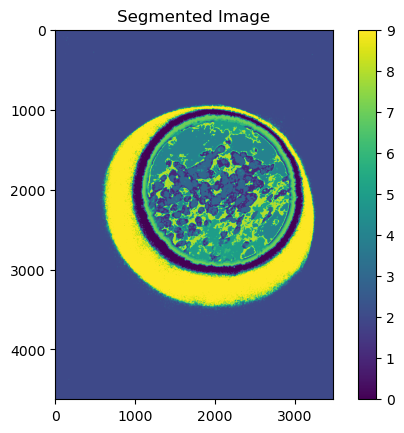

In [37]:
def preprocess_image(image_path):
    # Load the image from the specified path and ensure it's in RGB format.
    image = Image.open(image_path).convert('RGB')
    
    # Convert the image into a NumPy array for further processing.
    image_np = np.array(image)
    
    # Reshape the image array into a 2D array where each row represents a pixel
    # and the 3 columns represent the RGB color values of that pixel.
    image_reshaped = image_np.reshape((-1, 3))  # Reshape to (number_of_pixels, 3)
    
    return image_reshaped, image_np

def segment_image(image_reshaped, n_clusters=5):
    # Initialize the KMeans clustering model with the specified number of clusters (default is 5).
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit the KMeans model to the image data. Each pixel is assigned a cluster label.
    kmeans.fit(image_reshaped)
    
    # Retrieve the cluster labels for each pixel.
    labels = kmeans.labels_
    
    return labels

def visualize_segmented_image(labels, image_shape):
    # Reshape the 1D array of labels back into the original image dimensions
    # (height x width) to visualize it as an image.
    segmented_image = labels.reshape(image_shape[:2])
    
    # Show the image
    plt.imshow(segmented_image, cmap='viridis')
    
    # Add a title and other stuff 
    plt.title("Segmented Image")
    plt.colorbar()
    plt.show()


# Main execution
image_path = '/home/iambrink/NOH_Thyroid_Cancer_Data/TAN/002/IMG_20220908_125052.jpg'  # Replace with the path to your image
image_reshaped, image_np = preprocess_image(image_path)

# Apply KMeans segmentation

'''
With this segmentation image here we can define the cluster as any number we want, however
the larger number of clusters the easier and better it is to visualize what the Model is segmenting
if you run an n_clusters=2 you will have a backdrop and a circle for the cell
if you run an n_clusters=10 you will have a detailed representaion of of what your cell looks like and all the niche things our untrained eyes cant see
'''

labels = segment_image(image_reshaped, n_clusters=10)

# Visualize the segmented image
visualize_segmented_image(labels, image_np.shape)


# Segmented Image Over Initial Image

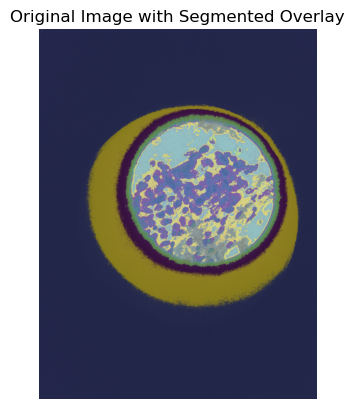

In [ ]:
def overlay_segmented_image(image_np, labels, alpha=0.5):
    # Reshape labels to match image dimensions
    segmented_image = labels.reshape(image_np.shape[:2])
    
    # Normalize labels to range [0, 1] for visualization
    normalized_labels = segmented_image / segmented_image.max()
    
    # Use viridis colormap to generate colors for the overlay
    colormap = plt.cm.viridis(normalized_labels)
    
    # Combine the original image with the colormap overlay
    overlay = (1 - alpha) * image_np / 255.0 + alpha * colormap[:, :, :3]
    
    # Display the overlaid image
    plt.imshow(overlay)
    plt.title("Original Image with Segmented Overlay")
    plt.axis("off")
    plt.show()

# Call the function
overlay_segmented_image(image_np, labels)


# Cluster Isolation 

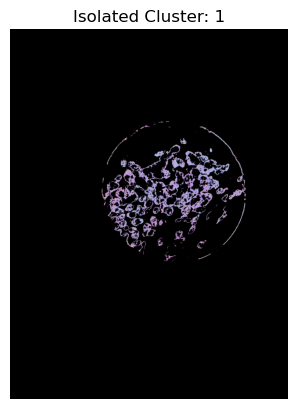

In [ ]:
def isolate_cluster(image_np, labels, target_cluster):
    
    # Reshape labels to match image dimensions
    segmented_image = labels.reshape(image_np.shape[:2])
    
    # Create a mask for the target cluster
    mask = (segmented_image == target_cluster).astype(np.uint8)
    
    # Apply the mask to the original image (only retain the target cluster's region)
    isolated_image = image_np * mask[:, :, None]
    
    # Display the isolated cluster
    plt.imshow(isolated_image)
    plt.title(f"Isolated Cluster: {target_cluster}")
    plt.axis("off")
    plt.show()

# Call the function for a specific cluster 
isolate_cluster(image_np, labels, target_cluster=1)


# Unsupervised Model

# Heat Map With Dino